# Minecraft DSCI100 Group Project

## DESCRIPTION OF DATA SETS: ##
### players.csv ###
This data set has 196 observations with 7 variables

| Variable Name | Type   | Meaning |
|----------------|-------------------|----------|
| experience     | Categorical (factor) | Player's Experience Level (Beginner, Amateur, Regular, Pro, Veteran|
| subscribe      | Logical (True/False)  | TRUE = Subcribed, otherwise, unsubscribed |
| hashedEmail    | chr    | Hashed Email of a Player |
| played_hours   | numeric (float)  | Number of Hours Played |
| name           | chr  | Player's Name |
| gender         | Categorical (factor)  | Geneder of Player |
| Age            | numeric (int)  | Age of Player |

Figure 1. Description of players.csv dataset

### sessions.csv ###
This data set has 1535 observations with 5 variables
| Variable Name | Type   | Meaning |
|----------------|-------------------|----------|
| hashedEmail    | Character | Anonymized unique player identifier |
| start_time     | Datetime (string)  | Timestamp for when session started in DD/MM/YYYY HH:MM format|
| end_time       | Datetime (string)  | Timestamp for when session ended in DD/MM/YYYY HH:MM format |
| original_start_time | numeric (float)  | Start time in milliseconds since 01/01/1970 |
| original_end_time   | numeric (float)  | End time in milliseconds since 01/01/1970 |

Figure 2. Description of sessions.csv dataset

### Potential Issues ###
- In players.csv, the column names are not standardized. Age is capitalized, while the other variable names are not
- In players.csv, experience could be self-reported, which might be an inaccurate representation of actual skill


### How Data Was Collected ###
- Player information collected through self-reporting
- Unique hashedEmail assigned randomly for identification
- Played_hours obtained by recording the player's total playtime

## Question ##
The broad question we aim to address is:

**“Can player characteristics be used to predict behavioural outcomes in the dataset?”**

The specific question we focus on is:

**“From the players.csv dataset, can a player’s age and playtime hours predict whether they will subscribe to a game-related newsletter?”**

To answer this question, we will build a k-nearest neighbours (k-NN) classification model, where:

Response variable:
- subscribe (yes/no)

Explanatory variables:
- age (numeric)
- playtime_hours (numeric)

The players.csv dataset contains all three of these variables, which allows us to construct a predictive model. Because the k-NN algorithm requires numerical predictors, we selected age and playtime hours as they are both quantitative and suitable for distance-based methods.

# Methods and Results

This project can be split up into 3 subsections:

### Initial data processing
- Import libraries and load players.csv dataset from the URL.
- Clean and wrangle data to the necessary format for analysis.
- Split the data into training and testing sets.
- Create summary statistics for the training set to make predictions about the classifier.
- Visualize the relationship between players' age and played hours to understand data distribution.
- Create a recipe for preprocessing (normalising predictors for k-NN)
- Define an initial k-NN model with neighbors = tune() to allow k to be selected.
- Use cross-validation and a tuning grid to test multiple k values and identify the best-performing k.
  
### Visualization
- To visualize our results, we plotted age on the x-axis and played_hours on the y-axis, using subscribe to colour the points.
- To check for over/underfitting, we coloured the background of the graph based on what prediction would be made at every possible point, allowing quick identification of how the model classified patients, and where the boundaries were.
  
### Classifier evaluation
- made a new model specification for the best k value chosen, combined it with the recipe, and fitted the classifier to the training set.
- predicted on the testing set to test the classifier's accuracy on unseen data.
- created a confusion matrix to establish which predictions were the most accurate and the consequential effects on real-world application.

## Initial Setup (importing necessary libraries)

In [10]:
# Importing libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
options(repr.matrix.max.rows = 10)
set.seed(1234)

options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Dig deeper into tidy modeling with R at https://www.tmwr.org



## Reading in the Data

To answer our question, we will only be using the players.csv dataset. It can be loaded into R using the following line of code:

In [7]:
players_data <- read_csv("https://raw.githubusercontent.com/sophiaymeng/dsci_100_008_7_minecraft/refs/heads/main/data/players%20(1).csv", show_col_types = FALSE)|>
    rename(age = Age) 
head(players_data)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Figure 3: players.csv dataset

## Wrangling and Cleaning the Data
Next, we minimally wrangeld the data so that rows containing NA were removed.

In [8]:
players_data <- players_data |>
    mutate(experience = as_factor(experience),
           subscribe = as_factor(subscribe),
           name = as_factor(name), 
           gender = as_factor(gender), 
           hashedEmail = as_factor(hashedEmail)) |>
    drop_na(age)
head(players_data)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Figure 4. Tidy players.csv dataset

## Splitting the Data into Training and Testing Sets

To make predictions with our data, we need to first split it into training and testing sets. We chose to split the data with 75% of the data in the training set and 25% in the testing set. This ratio allows us to train the model with as many data points as possible, while still having a sufficient amount of data to test the model.

We used initial_split to shuffle the data before splitting, ensuring that ordering of the data set does not affect the split. Additionally, we also stratify it by subscription to ensure approximately equal proportions per class in each set.

Finally, we set a random seed  to ensure reproducibility.

In [11]:
set.seed(1234)

players_split <- players_data |>
    initial_split(prop = 0.75, strata = subscribe)

players_training <- training(players_split)
players_testing <- testing(players_split)

head(players_training)

nrow(players_training)
nrow(players_testing)

experience,subscribe,hashedEmail,played_hours,name,gender,age
<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>
Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
Amateur,FALSE,2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53,0.0,Quinlan,Male,22
Amateur,FALSE,200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687,0.1,Anastasia,Female,17
Veteran,FALSE,f8acd26a5e452b682b9f8b20108caef1ee2e745efe08e95806980bd2388a3fea,0.0,Finn,Male,23
Veteran,FALSE,951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd,0.1,Vivienne,Male,18
Veteran,FALSE,88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62,1.4,Aiden,Prefer not to say,25


[1] 145

[1] 49

Figure 5. Splitting the data

## Summarizing the Data

Before we create our prediction model, we calculated a summary of statistics regarding the relavant variables below.

In [13]:
players_summary <- players_data |>
                    group_by(subscribe) |>
                    summarize(mean_age = mean(age), 
                              min_age = min(age),
                              max_age = max(age),
                              mean_played_hours = mean(played_hours),
                              min_played_hours = min(played_hours),
                              max_played_hours = max(played_hours),
                              n_of_players = n())

players_summary

subscribe,mean_age,min_age,max_age,mean_played_hours,min_played_hours,max_played_hours,n_of_players
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
FALSE,23.7500,17,57,0.5019231,0,7.1,52
TRUE,20.1831,9,58,7.8830986,0,223.1,142


Figure 6. Summarized data

## Preliminary Data Visualization

To visualize the relationship that age and played hours have with a player's subscription status, we will use ggplot to generate a scatter plot of age vs played_hours, colouring for subscribe.



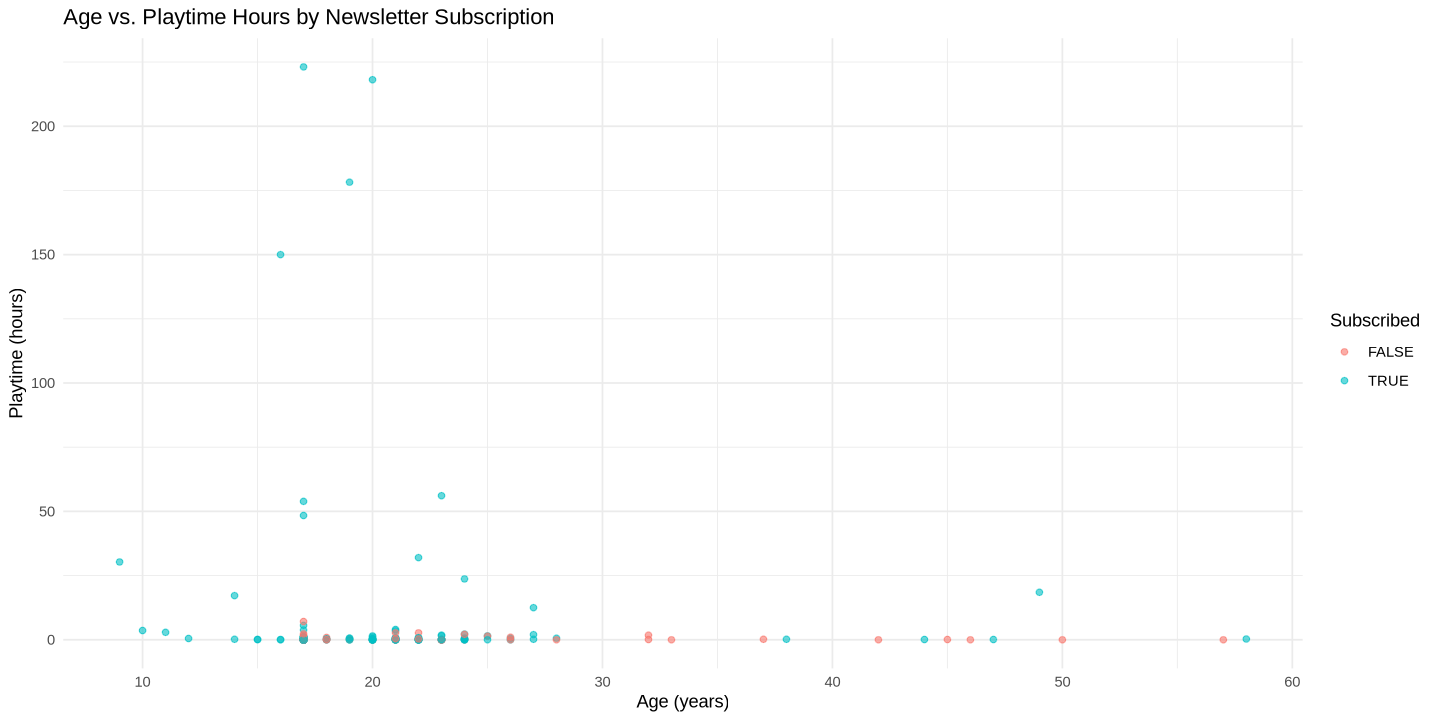

In [14]:
ggplot(players_data, aes(x = age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  labs(title = "Age vs. Playtime Hours by Newsletter Subscription",
       x = "Age (years)",
       y = "Playtime (hours)",
       color = "Subscribed") +
  theme_minimal()
     

This graph shows that unsubscribed players (red) tend to be older and play less, while subscribed players (teal) have a wider spread of age and playtime, with a tendency for longer playtime and younger. This plot shows that there is probably a relationship between these variables, which can be defined using predictive modelling.